This script computes the climatic fragility considering these aspects:
- Percentage of area with nature-based green solutions (such as public parks, urban forests, street trees... )
- Percentage of area with blue nature-based solutions (ponds, lakes, rivers...)
- Climate shelters score (if any)
- Percentage of heat island

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.9 MB/s eta 0:00:00


### 0. Libraries

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import numpy as np
import rasterstats
from rasterstats import zonal_stats
from matplotlib import pyplot as plt


### 1. Indicator for Climate fragility
Select only fully covered statistical areas

In [ ]:
# Load the shapefile containing the statistical areas of Comune di Bologna
#areas_gdf = gpd.read_file(r"D:\Meteoblue\aree-statistiche.shp")
areas_gdf = gpd.read_file(r"/data/Meteoblue/aree-statistiche.shp")

In [ ]:
# Open the TIFF file
with rasterio.open(r"/data/Meteoblue/Air_temperature_Bologna/Estati_22_23/reprojected_bologna/reprojected_bologna_2022060116Z.tif") as src:   # file of meteoblue about temperature
 # Get the bounds of the raster
    raster_bounds = src.bounds

    # Create a bounding box polygon from the raster bounds
    raster_box = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)

    # Check if each area is fully contained within the raster's bounding box
    fully_covered_mask = areas_gdf.geometry.within(raster_box)


In [ ]:
# Filter the areas GeoDataFrame to include only fully covered areas
fully_covered_areas_gdf = areas_gdf[fully_covered_mask]

<Axes: >

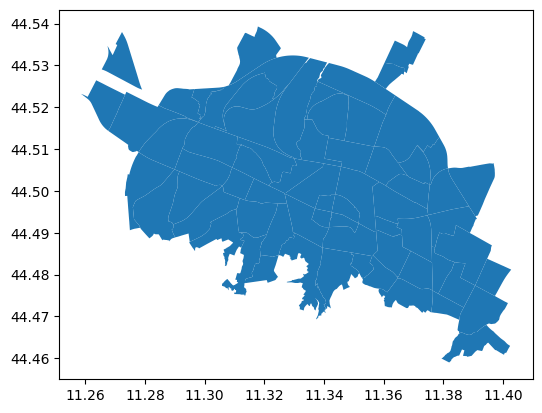

In [ ]:
fully_covered_areas_gdf.plot()

In [ ]:
print(list(fully_covered_areas_gdf['area_statis']))

['TRIUMVIRATO-PIETRA', 'CASTELDEBOLE', 'BATTINDARNO', 'LUNGO RENO', 'OSPEDALE BELLARIA', 'MEZZOFANTI', 'PESCAROLA', 'BEVERARA', 'MALPIGHI-1', 'STADIO-MELONCELLO', 'CASERME ROSSE-MANIFATTURA', 'CNR', 'ARCOVEGGIO', 'VIA FERRARESE', "PIAZZA DELL'UNITA'", 'BARGELLINO', 'EMILIA PONENTE', "OSPEDALE SANT'ORSOLA", 'MENGOLI', 'GUELFA', 'PRATI DI CAPRARA-OSPEDALE MAGGIORE', 'SCALO RAVONE', 'VIA VITTORIO VENETO', 'AGUCCHI', 'VIA DEL LAVORO', 'FOSSOLO', 'PONTEVECCHIO', 'GALVANI-1', 'GALVANI-2', 'DUCATI-VILLAGGIO INA', 'BORGO CENTRO', 'MULINO DEL GOMITO', 'OSSERVANZA', 'VILLAGGIO DELLA BARCA', 'SAN MICHELE IN BOSCO', 'GIARDINI MARGHERITA', 'LAZZARETTO', 'CANALE DI RENO', 'VIA ARNO', 'CIRENAICA', 'LA DOZZA', 'SAN GIUSEPPE', 'VIA DEL GENIO', 'VELODROMO', 'MICHELINO', 'VIA MONDO', 'IRNERIO-1', 'MARCONI-2', 'LA BIRRA', 'SIEPELUNGA', 'DAGNINI', 'MALPIGHI-2', 'CHIESANUOVA', 'XXI APRILE', 'EX MERCATO ORTOFRUTTICOLO', 'SCANDELLARA', 'VIA LARGA', 'MARCONI-1', 'RAVONE', 'ZANARDI', 'SAN DONNINO', 'DUE MADONNE

In [ ]:
fully_covered_areas_gdf.shape

(68, 7)

In [ ]:
# Save the fully covered areas to a new shapefile
fully_covered_areas_gdf.to_file(r"/data/Meteoblue/covered_areas.shp")

#### 1.1 Percentage of Green nature-based solutions

In [ ]:
# Load shapefiles
covered_areas = gpd.read_file(r"/data/Meteoblue/covered_areas.shp")   # statistical areas of bologna
green = gpd.read_file(r"/data/Bologna_DBSN/Bologna_dbsn_selected/Unione_all_gree_area.shp")  # green areas of bologna


In [ ]:
# Check crs
if covered_areas.crs != green.crs:
    raise ValueError('different crs!')

In [ ]:
covered_areas['green%'] = covered_areas.geometry.apply(lambda x: (x.intersection(green.unary_union).area / x.area) * 100)

/tmp/ipython-input-1236085594.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  covered_areas['green%'] = covered_areas.geometry.apply(lambda x: (x.intersection(green.unary_union).area / x.area) * 100)


In [ ]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,geometry,green%
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,...",64.106510
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,"POLYGON ((11.28826 44.50371, 11.28808 44.50357...",57.784692
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,"POLYGON ((11.30337 44.50128, 11.30366 44.50117...",54.386370
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,"POLYGON ((11.30661 44.52489, 11.30653 44.52477...",65.579211
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,"POLYGON ((11.39674 44.46646, 11.39726 44.46607...",63.030694


In [ ]:
# Save the result
#covered_areas.to_file("D:/Climatic_fragility/green_percentage.shp")
covered_areas.to_file("/data/Climatic_fragility/green_percentage.shp")

#### 1.2 Percentage of Blue nature-based solutions

In [ ]:
# Load shapefiles
covered_areas = gpd.read_file("/data/Climatic_fragility/green_blue_percentage.shp")   # statistical areas of bologna + percentage of green
blue = gpd.read_file("/data/Climatic_fragility/idrografia/all_blue_area.shp")  # blue areas of bologna

In [ ]:
# Check crs
if covered_areas.crs != blue.crs:
    raise ValueError('different crs!')

In [ ]:
covered_areas['blue%'] = covered_areas.geometry.apply(lambda x: (x.intersection(blue.unary_union).area / x.area) * 100)

/tmp/ipython-input-488360097.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  covered_areas['blue%'] = covered_areas.geometry.apply(lambda x: (x.intersection(blue.unary_union).area / x.area) * 100)


In [ ]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,geometry
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,..."
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,"POLYGON ((11.28826 44.50371, 11.28808 44.50357..."
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,54.386370,0.000000,"POLYGON ((11.30337 44.50128, 11.30366 44.50117..."
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,65.579211,8.792652,"POLYGON ((11.30661 44.52489, 11.30653 44.52477..."
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,63.030694,0.649383,"POLYGON ((11.39674 44.46646, 11.39726 44.46607..."


In [ ]:
#covered_areas.to_file("D:/Climatic_fragility/green_blue_percentage.shp")
covered_areas.to_file("/data/Climatic_fragility/green_blue_percentage.shp")

#### 1.3 Number of Climate Shelters and their scores


In [ ]:
# Load shapefiles
covered_areas = gpd.read_file("/data/Climatic_fragility/green_blue_percentage.shp")   # statistical areas of bologna + blue and green percentage
climate_shelters = gpd.read_file("/data/Climate_Shelter_Index/isocrona/CSI/CSI.shp")

In [ ]:
# Spatially join the two shapefiles to count the number of climatic refuges in each statistical area
joined = gpd.sjoin(covered_areas, climate_shelters, how="left", predicate="contains")

In [ ]:
# Group by the statistical areas and count the number of refuges in each area
cs_counts = joined.groupby('codice_are')['CSI'].count().reset_index(name='CS')

In [ ]:
# Group by the statistical areas and calculate the average 'CSI' score for refuges in each area
cs_avg = joined.groupby('codice_are')['CSI'].mean().reset_index()

In [ ]:
# Fill NaN values with 0
cs_avg['CSI'].fillna(0, inplace=True)

/tmp/ipython-input-2822068799.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cs_avg['CSI'].fillna(0, inplace=True)


In [ ]:
# Merge the 'CS' counts back into covered_areas based on the statistical area
covered_areas = covered_areas.merge(cs_counts, on='codice_are', how='left')

In [ ]:
# Merge the 'CSI' averages back into covered_areas based on the statistical area
covered_areas = covered_areas.merge(cs_avg, on='codice_are', how='left')

In [ ]:
covered_areas.rename(columns={'CSI': 'CSI_avg'}, inplace=True)

In [ ]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,geometry,CS,CSI_avg
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,...",16,0.116757
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,"POLYGON ((11.28826 44.50371, 11.28808 44.50357...",19,0.091588
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,54.386370,0.000000,"POLYGON ((11.30337 44.50128, 11.30366 44.50117...",28,0.068966
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,65.579211,8.792652,"POLYGON ((11.30661 44.52489, 11.30653 44.52477...",0,0.000000
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,63.030694,0.649383,"POLYGON ((11.39674 44.46646, 11.39726 44.46607...",3,0.076150


In [ ]:
# Save shapefile
#covered_areas.to_file("D:/Climatic_fragility/g_b_csi.shp")
covered_areas.to_file("/data/Climatic_fragility/g_b_csi.shp")

#### 1.4 Percentage of Heat Island

# Air Temperature Processing (vector file)
##Skip if using LST

In [ ]:
# Load the shapefile
covered_areas = gpd.read_file("/data/Climatic_fragility/g_b_csi.shp")   # statistical areas of bologna
hot_cold_spots = gpd.read_file("data/Meteoblue/Air_temperature_Bologna/Estati_22_23/Hot_Cold_Spot/hot_cold_spots_vector.shp")

In [ ]:
# Select hot and cold area
polygons_4 = hot_cold_spots[hot_cold_spots['DN'] == 4]
polygons_1 = hot_cold_spots[hot_cold_spots['DN'] == 1]

In [ ]:
covered_areas['hot_area%'] = covered_areas.geometry.apply(lambda x: (x.intersection(polygons_4.unary_union).area / x.area) * 100)

c:\Users\elima\anaconda3\envs\geoss\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [ ]:
covered_areas['cold_area%'] = covered_areas.geometry.apply(lambda x: (x.intersection(polygons_1.unary_union).area / x.area) * 100)

c:\Users\elima\anaconda3\envs\geoss\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [ ]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,geometry,hot_area%,cold_area%
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,16,0.116757,"POLYGON ((11.29699 44.51663, 11.29740 44.51652...",47.016418,0.000000
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,19,0.091588,"POLYGON ((11.28826 44.50371, 11.28808 44.50357...",41.735059,0.000000
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,54.386370,0.000000,28,0.068966,"POLYGON ((11.30337 44.50128, 11.30366 44.50117...",65.974661,0.000000
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,65.579211,8.792652,0,0.000000,"POLYGON ((11.30661 44.52489, 11.30653 44.52477...",17.813553,0.336931
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,63.030694,0.649383,3,0.076150,"POLYGON ((11.39674 44.46646, 11.39726 44.46607...",0.500572,58.199828


In [ ]:
# Save shapefile
#covered_areas.to_file("data/Climatic_fragility/g_b_csi_hot_cold.shp")

# LST Raster data processing

In [ ]:
# Load polygons (statistical areas)
covered_areas = gpd.read_file("/data/Climatic_fragility/g_b_csi.shp")

# Path to your ECOSTRESS classified raster (added step for LST raster)
lst_classified = "/data/LST_hot_cold_classified.tif"

# Match CRS between polygons and raster
with rasterio.open(lst_classified) as src:
    raster_crs = src.crs
covered_areas = covered_areas.to_crs(raster_crs)

# Compute zonal stats
zs = zonal_stats(
    covered_areas,
    lst_classified,
    categorical=True,
    nodata=0
)

# Compute % of each class
hot_percentages = []
cold_percentages = []

for zone in zs:
    total = sum(zone.values())
    hot_percent = (zone.get(4, 0) / total) * 100 if total > 0 else 0
    cold_percent = (zone.get(1, 0) / total) * 100 if total > 0 else 0
    hot_percentages.append(hot_percent)
    cold_percentages.append(cold_percent)

covered_areas["hot_area%"] = hot_percentages
covered_areas["cold_area%"] = cold_percentages


In [ ]:
covered_areas.to_file("/data/Climatic_fragility/g_b_csi_hot_cold_lst.shp")

In [ ]:
covered_areas[["hot_area%", "cold_area%"]].describe()


,hot_area%,cold_area%
count,68.000000,68.000000
mean,39.926850,22.857020
std,31.207775,31.249950
min,0.000000,0.000000
25%,6.748503,0.000000
50%,41.813294,2.702090
75%,72.500000,42.604274
max,91.017964,100.000000


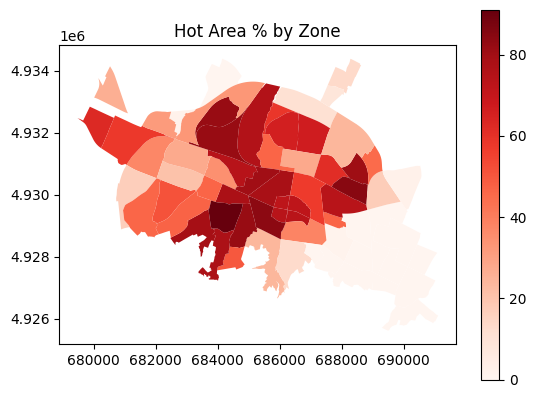

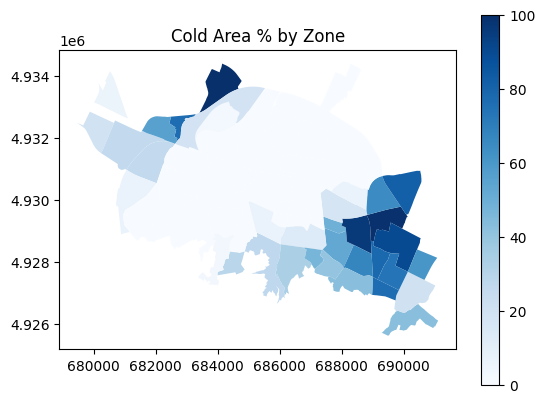

In [ ]:
covered_areas.plot(column='hot_area%', cmap='Reds', legend=True)
plt.title('Hot Area % by Zone')
plt.show()

covered_areas.plot(column='cold_area%', cmap='Blues', legend=True)
plt.title('Cold Area % by Zone')
plt.show()


### 2. Climate Fragility

In [ ]:
# load shapefile
#indicators = gpd.read_file("/data/Climatic_fragility/climate_fragility_index.shp")
#indicators = gpd.read_file("/data/Climatic_fragility/g_b_csi_hot_cold.shp") #airtemp
indicators = gpd.read_file("/data/Climatic_fragility/g_b_csi_hot_cold_lst.shp")  #LST

In [ ]:
indicators.head(2)

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,16,0.116757,37.104072,25.791855,"POLYGON ((682554.563 4931822.22, 682587.575 49..."
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,19,0.091588,16.742081,6.334842,"POLYGON ((681900.668 4930367.999, 681886.808 4..."


In [ ]:
# Normalize indicator
indicators_to_normalize = ['green%', 'blue%', 'hot_area%', 'cold_area%']
indicators[indicators_to_normalize] = indicators[indicators_to_normalize] / 100


In [ ]:
# Calculate fragility index
indicators['fragility'] = 1 - ((indicators['green%'] + indicators['blue%'] + indicators['CSI_avg']
                                + indicators['cold_area%']) - indicators['hot_area%'])

In [ ]:
indicators[indicators['codice_are']=='16']

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry,fragility
54,16,EX MERCATO ORTOFRUTTICOLO,12,Navile,B,Bolognina,0.280045,0.005404,4,0.267884,0.468085,0.0,"POLYGON ((686472.988 4930779.138, 686463.824 4...",0.914752


In [ ]:
# Identify min and max value of fragility
min_value = indicators['fragility'].min()
max_value = indicators['fragility'].max()

In [ ]:
# Normalize the fragility index
indicators['Nfragility']= (indicators['fragility'] - min_value) / (max_value - min_value)

In [ ]:
covered_areas_frag_sorted = indicators.sort_values(by='Nfragility', ascending=False).head(10)
covered_areas_frag_sorted

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry,fragility,Nfragility
21,32,SCALO RAVONE,13,Porto - Saragozza,P,Saffi,0.011894,0.000000,0,0.000000,0.741007,0.00000,"POLYGON ((683670.747 4931245.618, 683671.288 4...",1.729113,1.000000
8,78,MALPIGHI-1,13,Porto - Saragozza,L,Malpighi,0.007724,0.000000,1,0.033492,0.736842,0.00000,"POLYGON ((686250.657 4929368.938, 686230.844 4...",1.695626,0.985584
27,53,GALVANI-1,15,Santo Stefano,G,Galvani,0.008865,0.000000,2,0.032603,0.733333,0.00000,"POLYGON ((686707.149 4929369.866, 686749.46 49...",1.691866,0.983965
46,60,IRNERIO-1,15,Santo Stefano,H,Irnerio,0.013632,0.000000,2,0.021053,0.718750,0.00000,"POLYGON ((686848.587 4929662.482, 686860.961 4...",1.684065,0.980607
57,30,MARCONI-1,13,Porto - Saragozza,M,Marconi,0.006284,0.000000,1,0.038003,0.722222,0.00000,"POLYGON ((686329.411 4929977.422, 686317.16 49...",1.677935,0.977968
51,77,MALPIGHI-2,13,Porto - Saragozza,L,Malpighi,0.110786,0.000000,8,0.034905,0.841772,0.06962,"POLYGON ((685052.057 4929940.198, 685183.756 4...",1.626461,0.955808
47,29,MARCONI-2,13,Porto - Saragozza,M,Marconi,0.105116,0.000776,18,0.064213,0.783333,0.00000,"POLYGON ((686211.413 4929965.924, 686208.163 4...",1.613228,0.950111
59,33,ZANARDI,13,Porto - Saragozza,P,Saffi,0.273771,0.000825,8,0.027467,0.801802,0.00000,"POLYGON ((685991.34 4930799.566, 685979.487 49...",1.499740,0.901254
53,72,XXI APRILE,13,Porto - Saragozza,F,Costa Saragozza,0.446105,0.000413,13,0.052426,0.910180,0.00000,"POLYGON ((684369.902 4929687.034, 684377.122 4...",1.411235,0.863153
22,35,VIA VITTORIO VENETO,13,Porto - Saragozza,P,Saffi,0.348545,0.000000,4,0.034675,0.776596,0.00000,"POLYGON ((685047.221 4929718.285, 685024.075 4...",1.393376,0.855465


In [ ]:
indicators[indicators['Nfragility']>0.8]

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry,fragility,Nfragility
8,78,MALPIGHI-1,13,Porto - Saragozza,L,Malpighi,0.007724,0.000000,1,0.033492,0.736842,0.00000,"POLYGON ((686250.657 4929368.938, 686230.844 4...",1.695626,0.985584
21,32,SCALO RAVONE,13,Porto - Saragozza,P,Saffi,0.011894,0.000000,0,0.000000,0.741007,0.00000,"POLYGON ((683670.747 4931245.618, 683671.288 4...",1.729113,1.000000
22,35,VIA VITTORIO VENETO,13,Porto - Saragozza,P,Saffi,0.348545,0.000000,4,0.034675,0.776596,0.00000,"POLYGON ((685047.221 4929718.285, 685024.075 4...",1.393376,0.855465
27,53,GALVANI-1,15,Santo Stefano,G,Galvani,0.008865,0.000000,2,0.032603,0.733333,0.00000,"POLYGON ((686707.149 4929369.866, 686749.46 49...",1.691866,0.983965
44,48,MICHELINO,14,San Donato - San Vitale,Q,San Donato,0.408874,0.000000,10,0.065913,0.804124,0.00000,"POLYGON ((688844.669 4930386.6, 688841.129 493...",1.329337,0.827896
46,60,IRNERIO-1,15,Santo Stefano,H,Irnerio,0.013632,0.000000,2,0.021053,0.718750,0.00000,"POLYGON ((686848.587 4929662.482, 686860.961 4...",1.684065,0.980607
47,29,MARCONI-2,13,Porto - Saragozza,M,Marconi,0.105116,0.000776,18,0.064213,0.783333,0.00000,"POLYGON ((686211.413 4929965.924, 686208.163 4...",1.613228,0.950111
51,77,MALPIGHI-2,13,Porto - Saragozza,L,Malpighi,0.110786,0.000000,8,0.034905,0.841772,0.06962,"POLYGON ((685052.057 4929940.198, 685183.756 4...",1.626461,0.955808
53,72,XXI APRILE,13,Porto - Saragozza,F,Costa Saragozza,0.446105,0.000413,13,0.052426,0.910180,0.00000,"POLYGON ((684369.902 4929687.034, 684377.122 4...",1.411235,0.863153
57,30,MARCONI-1,13,Porto - Saragozza,M,Marconi,0.006284,0.000000,1,0.038003,0.722222,0.00000,"POLYGON ((686329.411 4929977.422, 686317.16 49...",1.677935,0.977968


In [ ]:
# Save shapefile
#indicators.to_file("/data/Climatic_fragility/climate_fragility_index.shp") #for air temp
indicators.to_file("/data/Climatic_fragility/climate_fragility_index_lst.shp")